We'd like to study how out model performs when applying various analyses to datasets not seen during its training. Here, we examine this problem using the set of human CDR3 TRB sequences.

In [1]:
cd ..

/home/romi/projects/preTCR


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import os, sys
import collections
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

SRC_DIR = "tcr"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from tcr import model_utils
from lab_notebooks.utils import TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

In [5]:
# generate matplotlib colors with names (for UMAP)
import matplotlib.colors as mcolors
def format_color_groups(df, color):
    x = df.copy()
    i = 0

    for factor in color:
        x.iloc[i, :-1] = ''
        style = f'background-color: {color[i]}'
        x.loc[i, 'display color as background'] = style
        i = i + 1

    return x

colors = {
    'name': mcolors.CSS4_COLORS.keys(),
    'hex': mcolors.CSS4_COLORS.values()
}
df_colors = pd.DataFrame(colors)
df_colors['rgb'] = df_colors['hex'].apply(mcolors.hex2color)
df_colors['rgb'] = df_colors['rgb'].apply(lambda x:[round(c, 5) for c in x])
df_colors['display color as background'] = ''
df_colors.style.apply(format_color_groups, color=df_colors.hex,  axis=None)

,name,hex,rgb,display color as background
0,aliceblue,#F0F8FF,"[0.94118, 0.97255, 1.0]",
1,antiquewhite,#FAEBD7,"[0.98039, 0.92157, 0.84314]",
2,aqua,#00FFFF,"[0.0, 1.0, 1.0]",
3,aquamarine,#7FFFD4,"[0.49804, 1.0, 0.83137]",
4,azure,#F0FFFF,"[0.94118, 1.0, 1.0]",
5,beige,#F5F5DC,"[0.96078, 0.96078, 0.86275]",
6,bisque,#FFE4C4,"[1.0, 0.89412, 0.76863]",
7,black,#000000,"[0.0, 0.0, 0.0]",
8,blanchedalmond,#FFEBCD,"[1.0, 0.92157, 0.80392]",
9,blue,#0000FF,"[0.0, 0.0, 1.0]",


In [6]:
# list of color names
list(df_colors['name'][5:20])
df_colors[5:20]

,name,hex,rgb,display color as background
5,beige,#F5F5DC,"[0.96078, 0.96078, 0.86275]",
6,bisque,#FFE4C4,"[1.0, 0.89412, 0.76863]",
7,black,#000000,"[0.0, 0.0, 0.0]",
8,blanchedalmond,#FFEBCD,"[1.0, 0.92157, 0.80392]",
9,blue,#0000FF,"[0.0, 0.0, 1.0]",
10,blueviolet,#8A2BE2,"[0.54118, 0.16863, 0.88627]",
11,brown,#A52A2A,"[0.64706, 0.16471, 0.16471]",
12,burlywood,#DEB887,"[0.87059, 0.72157, 0.52941]",
13,cadetblue,#5F9EA0,"[0.37255, 0.61961, 0.62745]",
14,chartreuse,#7FFF00,"[0.49804, 1.0, 0.0]",


#### Prepare Data

In [15]:
# flag for abundance (0) or publicness (1)
Appearance = "Appearance"
Abundance = "Abundance"
DISTRIB_TYPE = Appearance

In [8]:
if DISTRIB_TYPE=="Appearance":
    data_dir = DATA_DIR + "db_data_appearances.csv"
    # threshold 100 / 50
    # data_dir = DATA_DIR + "db_data_public_private_thresh_100.csv"
    # data_dir = DATA_DIR + "db_data_thresh_50_pub_priv.csv"
else:
    data_dir = DATA_DIR + "db_data_nuc_vj_genes_pub_priv.csv"

In [9]:
if DISTRIB_TYPE=="Appearance":
    tcrb_data = pd.read_csv(data_dir, engine="pyarrow")
else:
    tcrb_data = pd.read_csv(data_dir, usecols=["Sequences", "Appearances", "Private_Public_label"], engine="pyarrow")

# drop duplicates
tcrb_data_sample_from = tcrb_data.drop_duplicates()
tcrb_data_sample_from.head()

,Sequences,Appearances,Private_Public_label
0,CASSLGETQYF,16658,1
16658,CASSLGYEQYF,13739,1
30397,CASSLGGNTEAFF,12688,1
43085,CASSSSYEQYF,11649,1
54734,CASSLQETQYF,10902,1


In [10]:
len(tcrb_data_sample_from)

91758697

#### Analyze Appearances/Abundance

In [13]:
# add column of sequence lengths
tcrb_data_sample_from['Length'] = tcrb_data_sample_from['Sequences'].apply(len)

In [14]:
collections.Counter(tcrb_data_sample_from['Private_Public_label'])

Counter({1: 17562246, 0: 74196451})

In [16]:
if DISTRIB_TYPE == "Abundance":
    # for abundance
    tcrb_data_sample_from['publicness_bin'] = pd.cut(tcrb_data_sample_from.Appearances, bins=[0,1, 10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 400, 550, 750, 1000, 1500, 2500, 5000, 100000], labels=['0-1','1-10', '10-25','25-50','50-75', '75-100', '100-125', '125-150', '150-175','175-200', '200-250', '250-300', '300-400', '400-550', '550-750', '750-1000','1000-1500', '1500-2500', '2500-5000', '5000+'])
    tcrb_data_sample_from.publicness_bin.value_counts()
else:
    # for publicness
    tcrb_data_sample_from['publicness_bin'] = pd.cut(tcrb_data_sample_from.Appearances, bins=[0,1,10,25, 50, 100, 150, 200, 250, 300, 350, 400,450, 500,550, 600,650, 700,750, 800,850, 900,950,1000, 2000], labels=['0-1','1-10','10-25', '25-50', '50-100','100-150','150-200', '200-250', '250-300', '300-350','350-400', '400-450', '450-500','500-550','550-600','600-650', '650-700','700-750', '750-800', '800-850','850-900','900-950','950-1000','1000+'])
    tcrb_data_sample_from.publicness_bin.value_counts()

In [37]:
if DISTRIB_TYPE == "Abundance":
    stats = collections.Counter(tcrb_data_sample_from['publicness_bin'])
else:
    stats = collections.Counter(tcrb_data_sample_from['Appearances']) # to draw appearance histogram (no bins)
stats

Counter({nan: 871,
         '1000+': 2643,
         '950-1000': 342,
         '900-950': 415,
         '850-900': 430,
         '800-850': 557,
         '750-800': 631,
         '700-750': 750,
         '650-700': 869,
         '600-650': 1097,
         '550-600': 1301,
         '500-550': 1809,
         '450-500': 2131,
         '400-450': 2883,
         '350-400': 3790,
         '300-350': 5479,
         '250-300': 8011,
         '200-250': 13130,
         '150-200': 22923,
         '100-150': 50577,
         '50-100': 167544,
         '25-50': 363824,
         '10-25': 1131170,
         '1-10': 15779069,
         '0-1': 74196451})

In [39]:
# reverse order of stats dictionary
from collections import OrderedDict
reversed_stats = OrderedDict(reversed(list(stats.items())))

#### Visualize Distributions

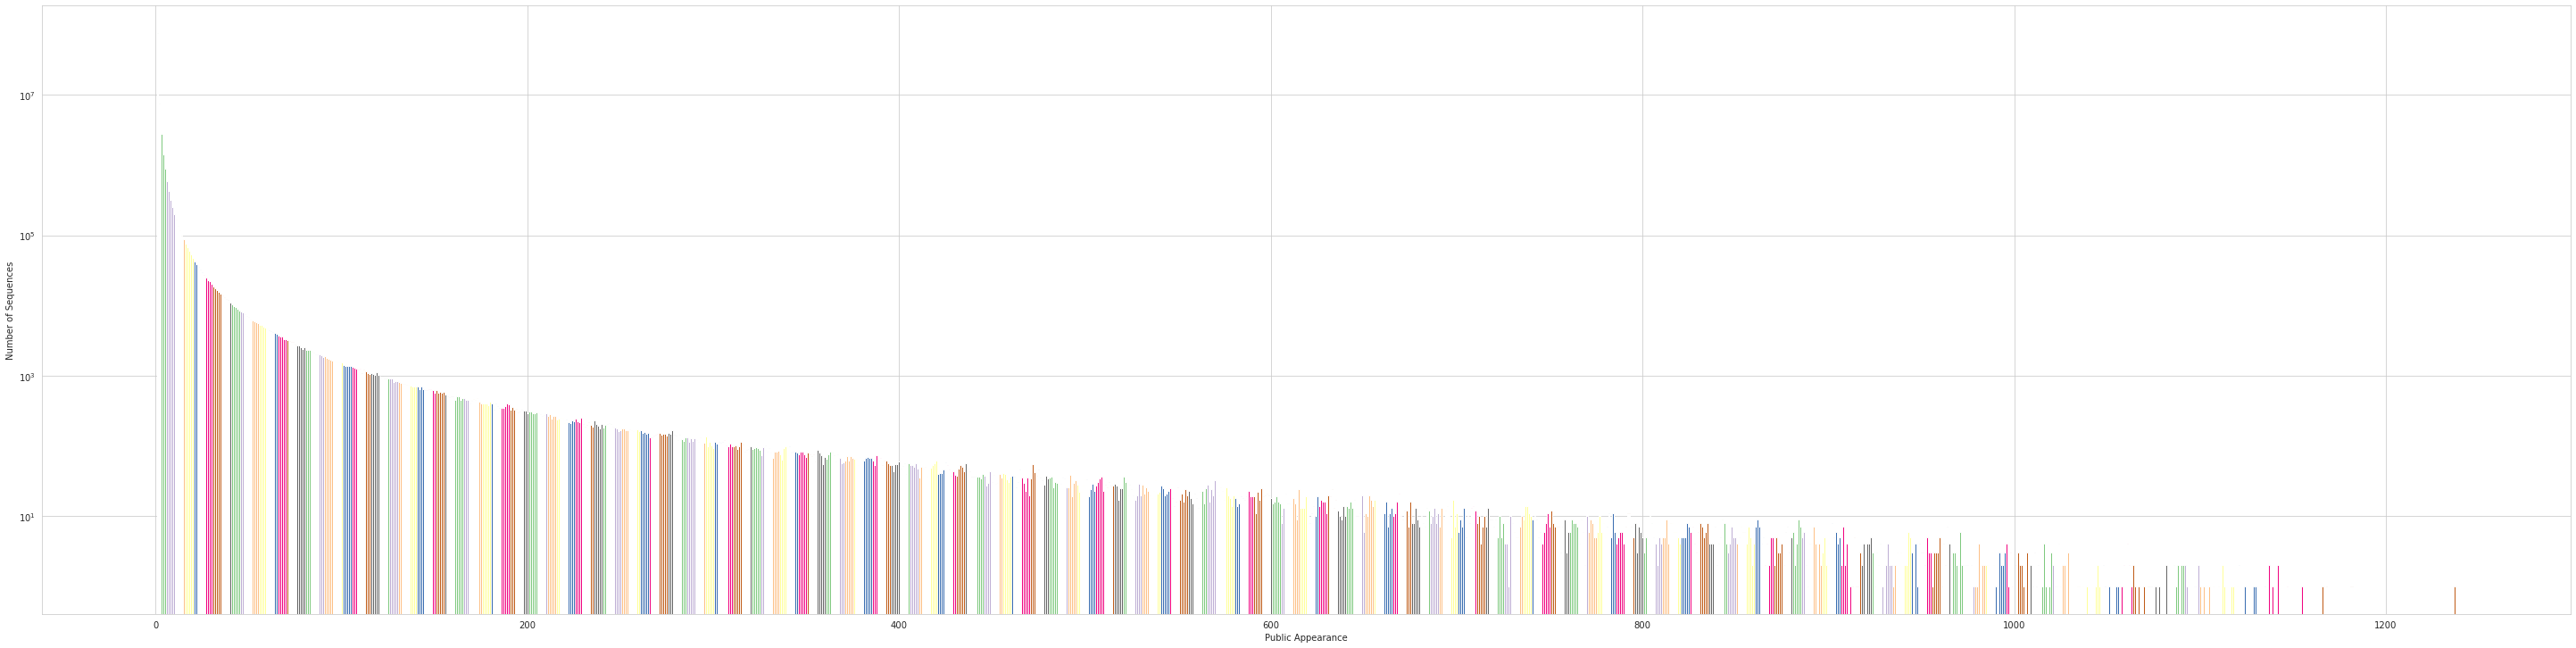

In [21]:
# bar plot for stats
plt.bar(list(reversed_stats.keys()), list(reversed_stats.values()), color=custom)
# plt.bar(list(reversed_stats.keys()), list(reversed_stats.values()), edgecolor='#1f77b4', color='#1f77b4')
# change y axis to log scale
plt.yscale('log')
# make the plot larger
plt.gcf().set_size_inches(40, 10)
# wider bars for better visualization
plt.tight_layout()
# set the x-axis label
x_label = "Public " + DISTRIB_TYPE
plt.xlabel(x_label)
# set the y-axis label
plt.ylabel('Number of Sequences')
# show plot
plt.show()

##### Number of Sequences per Appearance, Color - Length Percentile

In [115]:
# determine the quartile values to use with pd.cut
quartiles = tcrb_data_sample_from['Length'].quantile([.1, .25, .5, .75, .9]).tolist()

# add a lower and upper range for the bins in pd.cut
quartiles = [0] + quartiles + [float('inf')]

# add a quartiles column to groups, using pd.cut
tcrb_data_sample_from['Percentile'] = pd.cut(tcrb_data_sample_from['Length'], bins=quartiles,
                                             labels=['0-10%', '10-25%', '25-50%', '50-75%', '75-90%', '90-100%'])

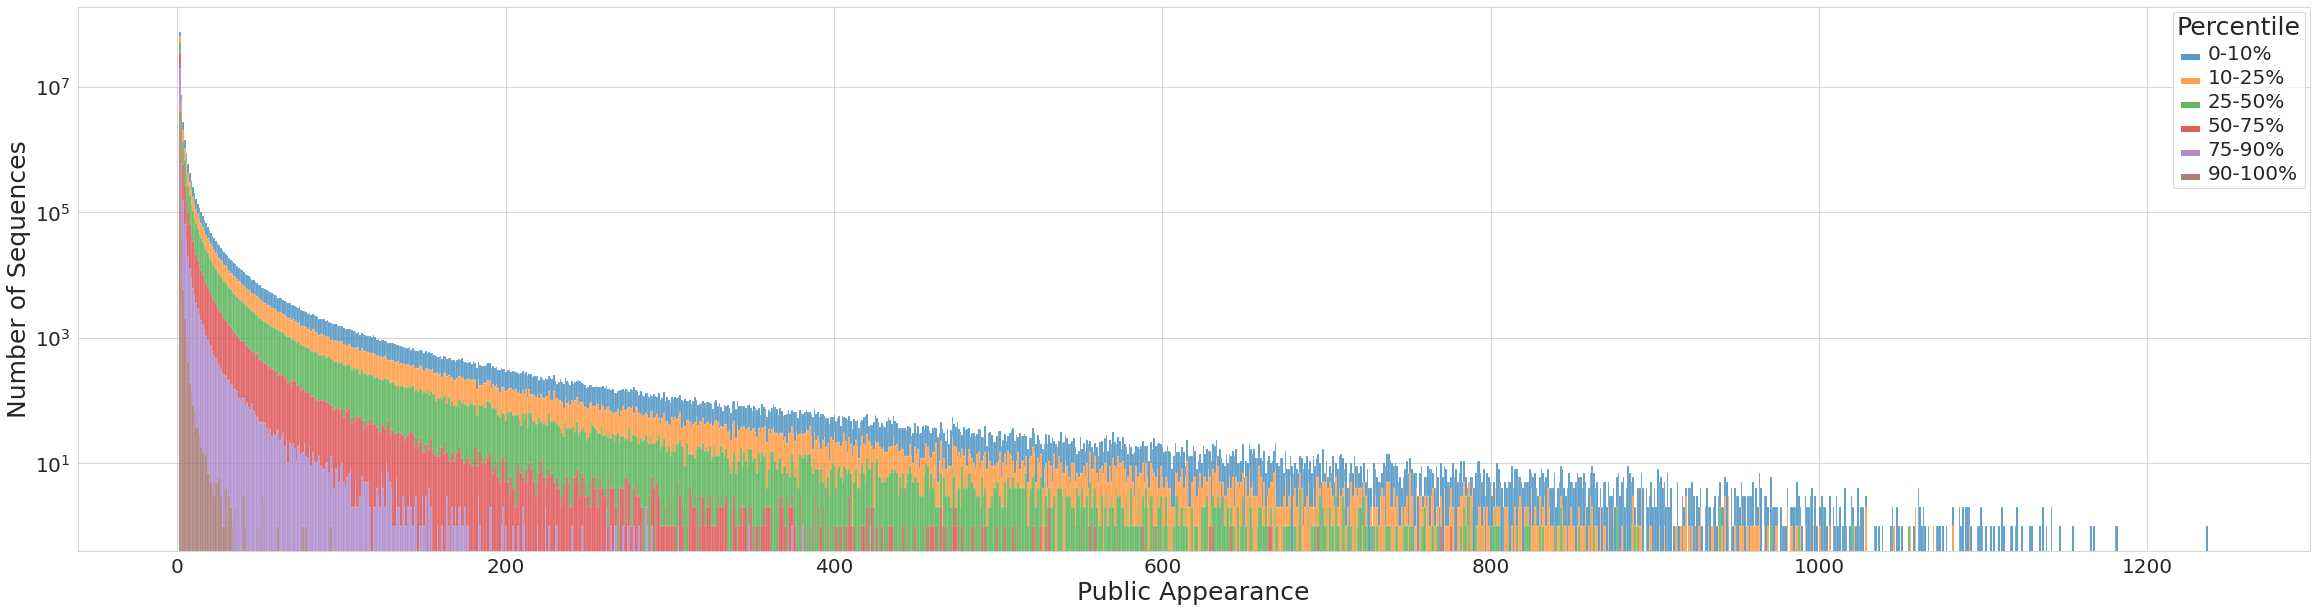

In [117]:
hex_colors_list = df_colors[:tcrb_data_sample_from.Length_bin.nunique()].hex.to_list()
fig, ax = plt.subplots(figsize=(40, 10))
# ax.legend(fontsize=20, title='Length bin', title_fontsize=25)
# g = sns.histplot(data=tcrb_data_sample_from.iloc[:], x='Appearances', hue='Length_bin', multiple="stack",
#                  bins=max(tcrb_data_sample_from['Appearances']))
g = sns.histplot(data=tcrb_data_sample_from.iloc[:], x='Appearances', hue='Percentile', multiple="stack",
                 bins=max(tcrb_data_sample_from['Appearances']))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale('log')
x_label = "Public " + DISTRIB_TYPE
plt.xlabel(x_label, fontsize=25)
plt.ylabel('Number of Sequences', fontsize=25)
plt.setp(g.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(g.get_legend().get_title(), fontsize='25') # for legend title
plt.show()

In [ ]:
tcrb_data_sample_from.Percentile.value_counts()

##### Mean Appearance Per Length

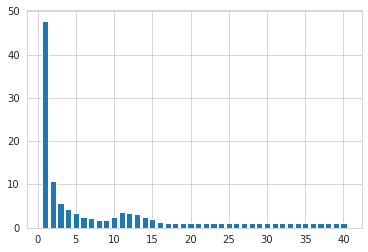

In [21]:
practice_data = tcrb_data_sample_from
df = practice_data.groupby('Length').mean()
df['Length'] = df.index
# Bar Plot
plt.bar(df['Length'],
        df['Appearances'])
# Show Plot
plt.show()

In [22]:
# Resamples df_counts into df_counts_small
def filter_data(df):
    if len(df) > 20_000_000:
        return df.sample(n=400_000)
    elif len(df) > 1_000_000:
        return df.sample(n=200_000)
    elif len(df) > 500_000:
        return df.sample(n=150_000)
    elif len(df) > 100_000:
        return df.sample(n=100_000)
    elif len(df) > 80_000:
        return df.sample(n=50_000)
    elif len(df) > 40_000:
        return df.sample(n=30_000)
    else:
        return df

df_counts_small = tcrb_data_sample_from.groupby('publicness_bin').apply(filter_data)
df_counts_small.publicness_bin.value_counts()

0-1         400000
1-10        200000
10-25       200000
25-50       100000
50-100      100000
100-150      30000
150-200      22923
200-250      13130
250-300       8011
300-350       5479
350-400       3790
400-450       2883
1000+         2643
450-500       2131
500-550       1809
550-600       1301
600-650       1097
650-700        869
700-750        750
750-800        631
800-850        557
850-900        430
900-950        415
950-1000       342
Name: publicness_bin, dtype: int64

In [23]:
df_counts_small

Sequences  Appearances  Private_Public_label  \
publicness_bin                                                                 
0-1            172965751      CSARAGSELFF            1                     0   
               194867113  CASSPVRGVNNEQFF            1                     0   
               179755739      CSTPLGVPQYF            1                     0   
               185112046  CSATPQDRGSFEQFF            1                     0   
               174986431    CSATGTRTLEQYF            1                     0   
...                                   ...          ...                   ...   
1000+          6337443       CASSLGVDTQYF         1001                     1   
               6338444      CASSPGYQETQYF         1001                     1   
               6339445       CASSLVSGELFF         1001                     1   
               6340446      CASSSDGNTEAFF         1001                     1   
               6341447       CASSLTPYEQYF         1001                     1   

                          Length publicness_bin  
publicness_bin                                   
0-1            172965751      11            0-1  
               194867113      15            0-1  
               179755739      11            0-1  
               185112046      15            0-1  
               174986431      13            0-1  
...                          ...            ...  
1000+          6337443        12          1000+  
               6338444        13          1000+  
               6339445        12          1000+  
               6340446        13          1000+  
               6341447        12          1000+  

[1099191 rows x 5 columns]

#### Subsample Data

In [24]:
# for appearance plotting
tcrb_data_sample = df_counts_small

In [ ]:
# sample 500,000 rows
#tcrb_data_sample = tcrb_data_sample_from.sample(n=500000)

# for db data (for equal distributions between plots)
# We will sample 15% public and 85% private sequences to have a roughly equal distribution to previous samplings.
TOTAL_COUNT = 1000000
PUBLIC_COUNT = int(.15 * TOTAL_COUNT)
PRIVATE_COUNT = int(.85 * TOTAL_COUNT)
public_sample = tcrb_data_sample_from.query('Private_Public_label == 1').sample(PUBLIC_COUNT, random_state=10)
private_sample = tcrb_data_sample_from.query('Private_Public_label == 0').sample(PRIVATE_COUNT, random_state=10)
# join public and private samples
tcrb_data_sample = pd.concat([public_sample, private_sample])

#### Genarate 1000 random sequences

In [ ]:
# # Generate 10000 random sequences size 11 - 20 with even distribution of amino acids
# amino_acids = ['R','H','K','D','E','S','T','N','Q','C','U','G','P','A','V','I','L','M','F','Y','W']
# RANDOM_SEQ_NUM = 10000
# seq = ""
# seq_list = list()
# from random import randint
# for i in range(RANDOM_SEQ_NUM):
#     seq = ""
#     length = randint(10,20)
#     m = 0
#     while m<=length:
#         seq += amino_acids[randint(0,len(amino_acids)-1)]
#         m+=1
#     seq_list.append(seq)
# seq_list
#
# # create dataframe from sequence list
# data_for_df = {'Sequences': seq_list, 'Private_Public_label': 2, 'Appearances':0}
# random_seq_df = pd.DataFrame(data_for_df)

In [ ]:
# # concat to tcrb_data_sample
# # join public and private samples
# tcrb_data_sample_concatinated = pd.concat([tcrb_data_sample, random_seq_df])
# tcrb_data_sample = tcrb_data_sample_concatinated
# tcrb_data_sample

#### Create and Display embeddings

In [ ]:
from cvc.embbeding_wrapper import EmbeddingWrapper
# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, tcrb_data_sample, batch_size=1024, method="mean", layers=[-1])
embed_wrap.embeddings.shape

tcrb_embeddings_adata = embed_wrap.create_anndata()

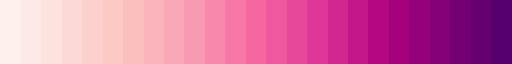

In [40]:
# Create colormap of 16 shades
num_colors = len(stats)
color_map = ListedColormap(sns.color_palette("RdPu", num_colors))
color_map

In [42]:
color_vals = tcrb_embeddings_adata.obs['publicness_bin']
unique_val = color_vals.values.categories.values
color_idx = [list(unique_val).index(i) for i in color_vals]
color_vals.values.categories.values

In [44]:
## plot_utils needs to be re-imported (after edit) if the desired umap needs to be colored by bin appearance.
## The default code changed the order of the bins and makes the output incorrect.
from tcr import plot_utils

In [ ]:
# Plot embeddings
embed_wrap.plot_embedding(
    color_embed='cluster',
    color_map=plt.get_cmap('tab20'),
    title="Top 20 clusTCR Clusters in Embedding Space",
    legend_size=3,
    plot_pdf_path=os.path.join(PLOT_DIR, "clusTCR_umap_2.5_mil_model.pdf"),
)

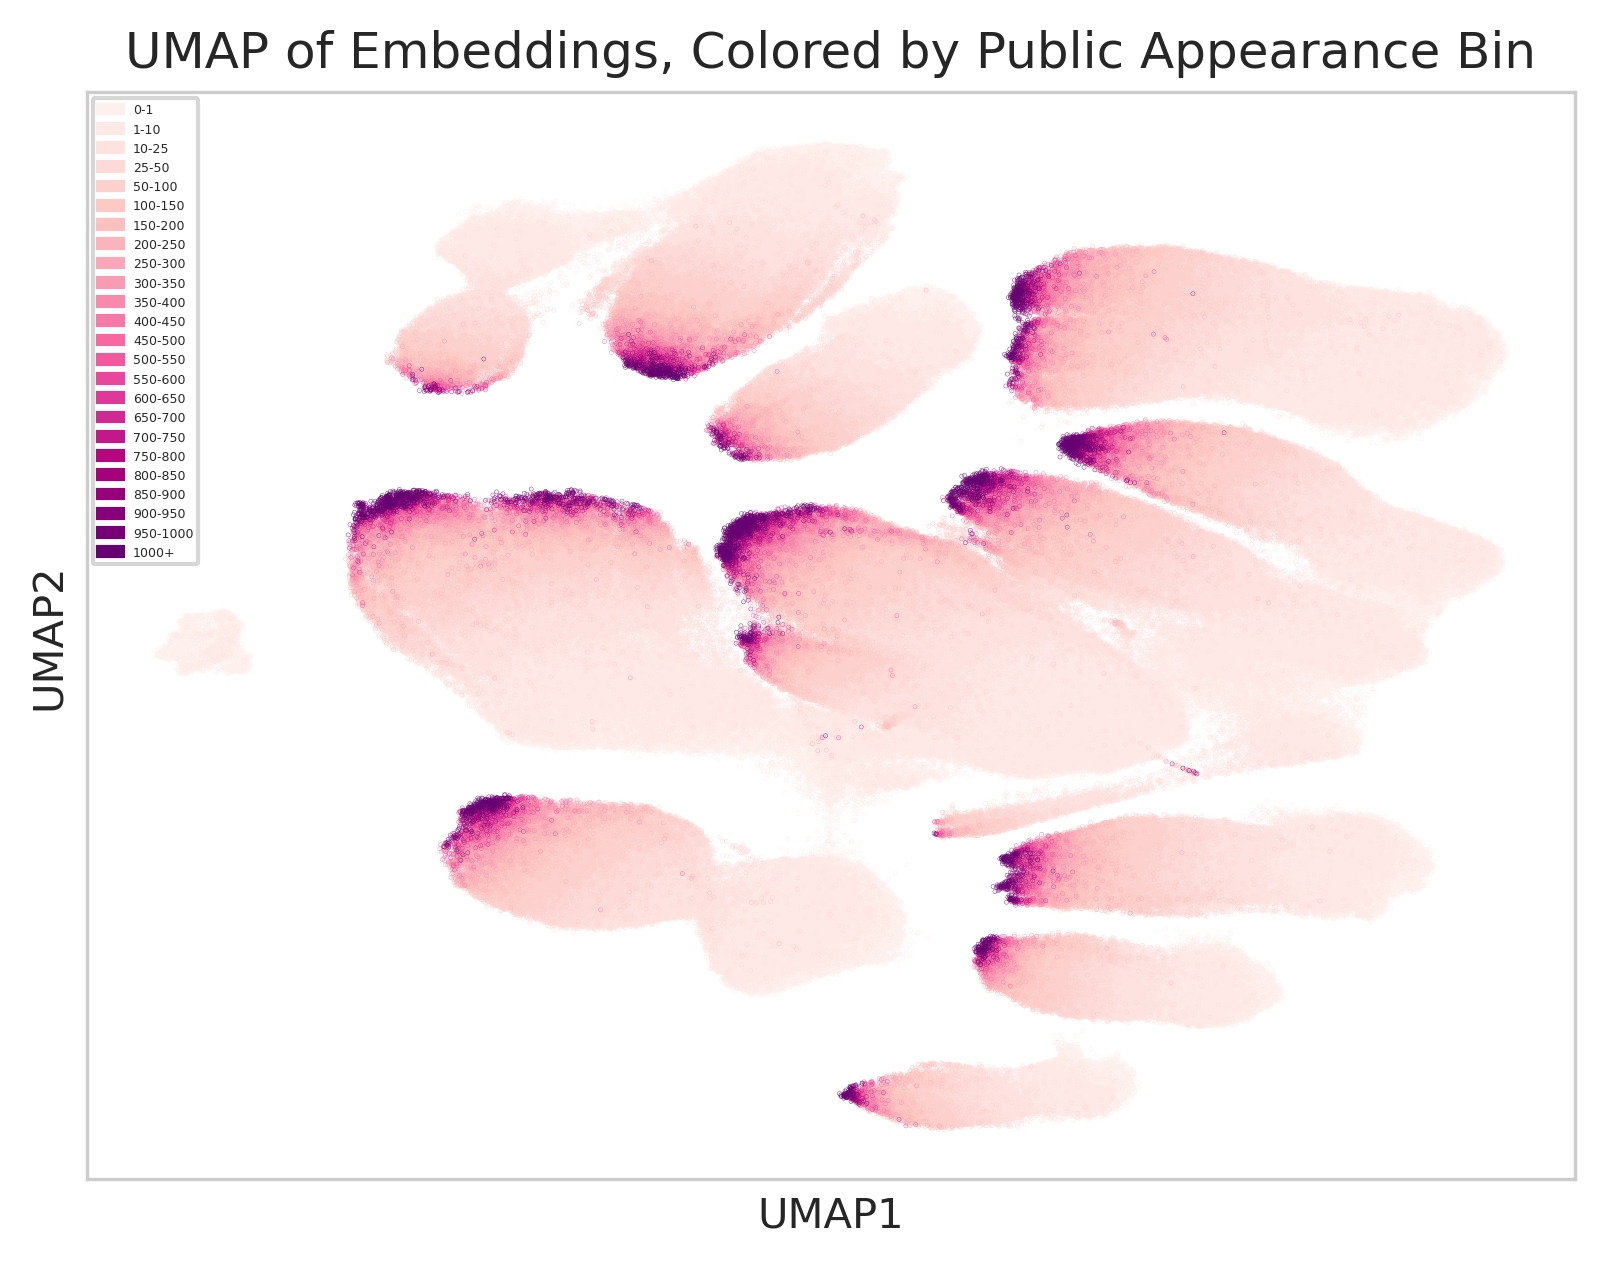

In [45]:
colors = ['gold', 'darkblue']#, 'maroon'] #cmap=plt.get_cmap('Set1)'
#colors = ['gold', 'darkblue', 'darkgreen']

importlib.reload(plot_utils)
plot_utils.plot_anndata_rep(
    tcrb_embeddings_adata,
    #color='Private_Public_label',
    color='publicness_bin',
    direct_label=False,
    cmap= color_map,#matplotlib.colors.ListedColormap(colors),#
    # cmap=matplotlib.colors.ListedColormap(colors),
    #title="UMAP of Embeddings with 10,000 Randomly Generated Sequences",
    #title="UMAP of Embeddings, Public Sequence Threshold=100",
    # title="UMAP of Embeddings, Public Sequence Threshold=50",
    # title="UMAP of Embeddings",
    title="UMAP of Embeddings, Colored by Public Appearance Bin",
    # title="UMAP of Embeddings, Colored by Public/Private Label",
    legend_size=3,
    #fname=os.path.join(PLOT_DIR, "tcr_bert_nofar_data_umap.pdf"),
    #fname=os.path.join(PLOT_DIR, "tcr_model_nofar_data_umap_10k_rand.pdf"),
    # fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap.pdf"),
    # fname=os.path.join(PLOT_DIR, "umap_appearance_pub_priv_db_data.pdf"),
    fname=os.path.join(PLOT_DIR, "umap_by_appearance_db_data.pdf")
    # fname=os.path.join(PLOT_DIR, "umap_by_appearance_db_data_2.pdf"),
    # fname=os.path.join(PLOT_DIR, "umap_by_abundance_db_data.pdf"),
    #fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap._new.pdf"),
    #fname=os.path.join(PLOT_DIR, "tcr_model_db_data_thresh_100_umap_new.pdf"),
    # fname=os.path.join(PLOT_DIR, "tcr_model_db_data_thresh_50_umap_new.pdf"),
    #fname=os.path.join(PLOT_DIR, "tcr_model_db_data_umap_10k_rand.pdf"),
).show()